# Pre-processing External Datasets

In [20]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Read in datasets
income_df = pd.read_csv("datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_personal_income_total_income_sa2_2011_2018.csv")
population_df = pd.read_csv("datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_regional_population_sa2_2001_2021.csv")

# Drop irrelevant attributes for income dataset
suburb_info = income_df[["sa2_code", "sa2_name"]]
income_df = income_df.loc[:, "mean_aud_2011_12":]
income_df = income_df.join(suburb_info)

# Rename attributes for income dataset
income_df.columns = ["mean_income_2011_12", "mean_income_2012_13", "mean_income_2013_14", "mean_income_2014_15", 
                     "mean_income_2015_16", "mean_income_2016_17", "mean_income_2017_18", "geometries", "suburb_code", 
                     "suburb"]

# Drop irrelevant attributes for population dataset
estimated_population = population_df.loc[:, "erp_2001":"erp_2021"]
population_df = population_df[["state_name_2016", "sa2_maincode_2016", "sa2_name_2016", "erp_change_per_cent_2020_21", 
                               "area_km2", "pop_density_2021_people_per_km2", "births_2016_17", "deaths_2016_17", 
                               "births_2017_18", "deaths_2017_18", "births_2018_19", "deaths_2018_19", "births_2019_20", 
                               "deaths_2019_20", "births_2020_21", "deaths_2020_21", "geom"]]
population_df = population_df.join(estimated_population)

# Rename attributes for population dataset
population_df.rename(columns={"state_name_2016":"state", "sa2_maincode_2016": "suburb_code", "sa2_name_2016": 
                                              "suburb", "erp_change_per_cent_2020_21": "change_in_population_percentage", 
                                              "area_km2": "suburb_area_km2", "pop_density_2021_people_per_km2": 
                                              "population_density_per_km2", "erp_2001": "population_2001", 
                                              "erp_2002": "population_2002", "erp_2003": "population_2003", 
                                              "erp_2004": "population_2004", "erp_2005": "population_2005", 
                                              "erp_2006": "population_2006", "erp_2007": "population_2007", 
                                              "erp_2008": "population_2008", "erp_2009": "population_2009", 
                                              "erp_2010": "population_2010", "erp_2011": "population_2011", 
                                              "erp_2012": "population_2012", "erp_2013": "population_2013", 
                                              "erp_2014": "population_2014", "erp_2015": "population_2015", 
                                              "erp_2016": "population_2016", "erp_2017": "population_2017", 
                                              "erp_2018": "population_2018", "erp_2019": "population_2019", 
                                              "erp_2020": "population_2020", "erp_2021": "population_2021"}, inplace=True)

# Filter instances in Victoria state for population dataset
population_df = population_df[population_df["state"] == "Victoria"]
suburb_code = population_df[["suburb_code"]]

# Filter instances in Victoria state for income dataset
income_df = pd.merge(income_df, suburb_code, on="suburb_code")

# Drop rows containing NaN values for income dataset
income_df = income_df.dropna().reset_index(drop=True)

# Drop rows without suburb code or suburb name for population dataset
population_df = population_df.dropna().reset_index(drop=True)

# Save dataframes as csv files
income_df.to_csv("income.csv", index=False)
population_df.to_csv("population.csv", index=False)

# Feature Engineering Primary Dataset

In [3]:
# Read in primary dataset
rental_df = pd.read_csv("All_Houses_Scraped.csv")

# Obtain all suburb names in Victoria
state_suburbs_df = pd.read_csv("georef-australia-state-suburb.csv")
state_suburbs_df = state_suburbs_df[state_suburbs_df["Official Name State"] == "Victoria"]
suburbs = [suburb.lower() for suburb in state_suburbs_df["Official Name Suburb"]]
for i in range(len(suburbs)):
    suburbs[i] = re.sub(r'\(.*\)', '', suburbs[i])
    suburbs[i] = suburbs[i].strip()

extra_suburbs = ["preston west", "prahran east", "sanctuary lakes", "mallacoota"]
for i in range(len(extra_suburbs)):
    suburbs.append(extra_suburbs[i])
    
# Convert address to list
rental_df["name"] = rental_df["name"].str.split(' ')

# Create new column for postcodes
rental_df["postcode"] = [row[-1] for row in rental_df["name"]]

# Create new columns for potential suburb names
rental_df["name_one"] = [row[-3].lower() for row in rental_df["name"]]
rental_df["name_two"] = [row[-4:-2] for row in rental_df["name"]]
rental_df["name_three"] = [row[-5:-2] for row in rental_df["name"]]

# Convert potential suburb names from list to string
rental_df["name_two"] = rental_df["name_two"].str.join(' ')
rental_df["name_two"] = [row.lower() for row in rental_df["name_two"]]
rental_df["name_three"] = rental_df["name_three"].str.join(' ')
rental_df["name_three"] = [row.lower() for row in rental_df["name_three"]]

i = 0
for suburb_one, suburb_two, suburb_three in zip(rental_df.iloc[:, -3], rental_df.iloc[:, -2], rental_df.iloc[:, -1]):
    if suburb_three in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_three
    elif suburb_two in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_two
    elif suburb_one in suburbs:
        rental_df.loc[i, ["suburb"]] = suburb_one
    i += 1

rental_df = rental_df.drop(columns=["name_one", "name_two", "name_three"])

# Drop rows containing at least one null value in primary dataset
rental_df = rental_df.dropna(axis=0, how ="any")

In [4]:
# Drop rows without room information
rental_df["rooms"] = rental_df["rooms"].replace("[]", np.nan)
rental_df = rental_df.dropna(subset = ["rooms"] , how="any").reset_index(drop=True)

# Set up cases for extracting room information
info_one = '|'.join(["bed"])
info_two = '|'.join(["bath"])
info_three = '|'.join(["park"])
numbers = '\d+[.,]?\d*'                              
case_one = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_one})'
case_two = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_two})'
case_three = fr'({numbers})(?:[\s\d\-\+\/]*)(?:{info_three})'
pattern_one = re.compile(case_one) 
pattern_two = re.compile(case_two) 
pattern_three = re.compile(case_three) 

# Create columns for the number of beedrooms, bathrooms and parking spaces
for i in range(len(rental_df)):
    rental_df["rooms"].loc[i] = literal_eval(rental_df["rooms"].loc[i])
    for j in range(len(rental_df["rooms"].loc[i])):
        rental_df["rooms"].loc[i][j] = rental_df["rooms"].loc[i][j].lower()     
        if pattern_one.findall(rental_df["rooms"].loc[i][j]) != []:
            rental_df.loc[i, "bedrooms"] = pattern_one.findall(rental_df["rooms"].loc[i][j])
        elif pattern_two.findall(rental_df["rooms"].loc[i][j]) != []:
            rental_df.loc[i, "bathrooms"] = pattern_two.findall(rental_df["rooms"].loc[i][j])
        else:
            rental_df.loc[i, "parking_spaces"] = pattern_three.findall(rental_df["rooms"].loc[i][j])

# Preliminary Analysis - Primary Dataset

In [72]:
# Create density plot 
def kde_plot(df, attribute, title, x_label, file_name):
    sns.kdeplot(data=df, x=attribute)
    plt.title(title)
    plt.xlabel(x_label)
    #plt.savefig(file_name + ".png", transparent=True, facecolor="white", bbox_inches="tight")
    plt.show()
    plt.close()
    
# Create scatter plot for attribute vs rental cost
def scatter_plot(df, attribute, x_label, title):
    plt.figure(figsize=(15,7))
    sns.scatterplot(data=df, x=attribute, y="cost_text")
    plt.xlabel(x_label)
    plt.ylabel("Rental Cost ($)")
    plt.title(title)
    plt.show()
    plt.close()
    
# Colour code each suburb based on distance to Melbourne CBD
def colour_code(suburb):
    if (0 <= suburb["CBD_Distance"] < 10):
        colour = "green"
    elif (10 <= suburb["CBD_Distance"] < 20):
        colour = "lime"
    elif (20 <= suburb["CBD_Distance"] < 30):
        colour = "yellow"
    elif (30 <= suburb["CBD_Distance"] < 40):
        colour = "gold"
    elif (40 <= suburb["CBD_Distance"] < 50):
        colour = "orange"
    elif (50 <= suburb["CBD_Distance"] < 60):
        colour = "tomato"
    elif (60 <= suburb["CBD_Distance"] < 100):
        colour = "red"
    elif (100 <= suburb["CBD_Distance"] < 150):
        colour = "darkred"
    elif (150 <= suburb["CBD_Distance"] < 200):
        colour = "purple"
    elif (200 <= suburb["CBD_Distance"] < 700):
        colour = "black"
    else:
        colour = "black"
        print("WHYYYY")
        print(suburb)
    return colour

In [70]:
rental_df = pd.read_csv("tmp_with_cbd_dist.csv")
print(rental_df)

       Unnamed: 0                 coordinates  cost_text  postcode  \
0               0  [-37.9032708, 145.0770553]      680.0      3166   
1               1   [-37.9077745, 145.092738]      650.0      3166   
2               2  [-37.8922004, 145.0899378]      500.0      3166   
3               3  [-37.8972564, 145.0871089]      570.0      3166   
4               4    [-37.894307, 145.082706]      475.0      3166   
...           ...                         ...        ...       ...   
12095       12095  [-37.8737803, 145.1426241]      415.0      3149   
12096       12096     [-37.88591, 145.119289]      470.0      3149   
12097       12097  [-37.8811914, 145.1387672]      510.0      3149   
12098       12098  [-37.8847588, 145.1379714]      650.0      3149   
12099       12099   [-37.8980896, 145.118164]      480.0      3149   

               suburb  bedrooms  bathrooms  parking_spaces  house_postcode  \
0          hughesdale         3          2             2.0            3166   
1  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


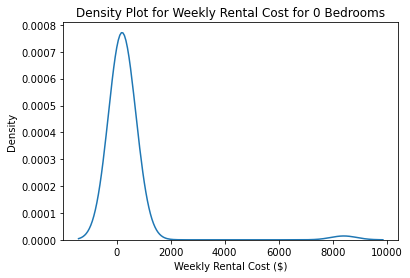

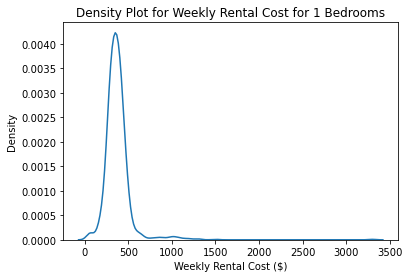

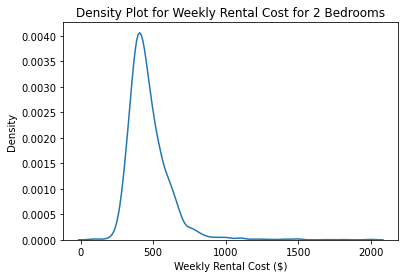

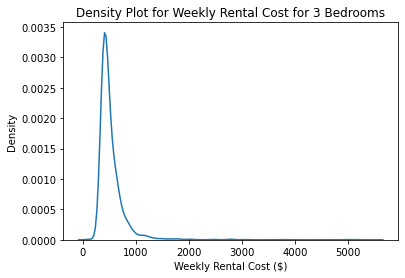

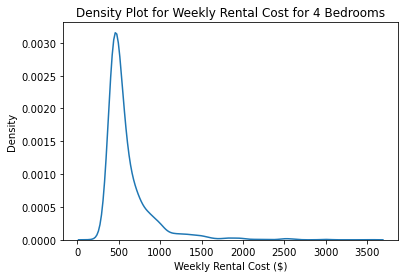

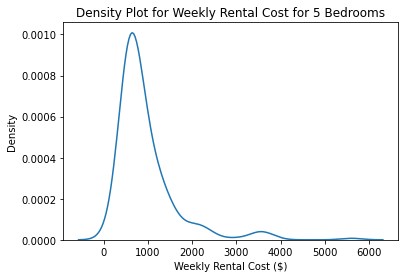

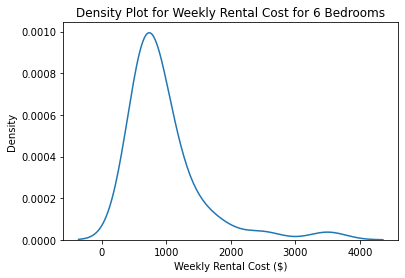

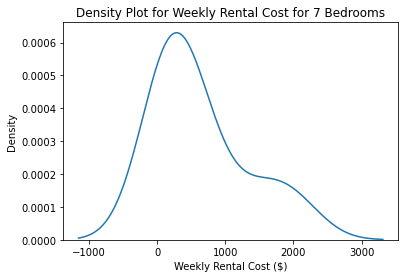

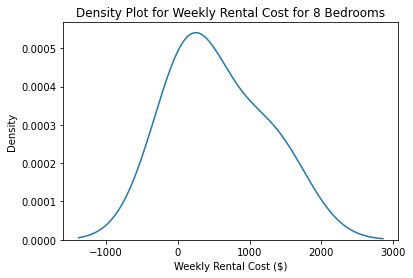

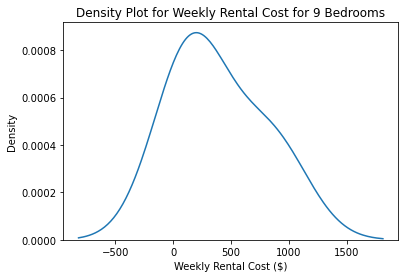

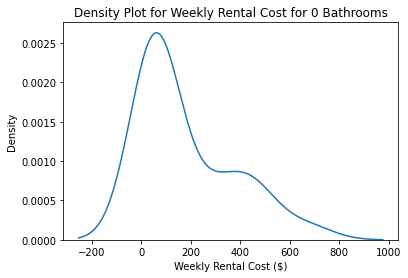

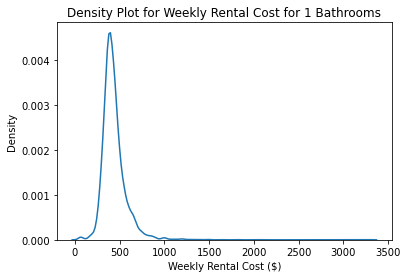

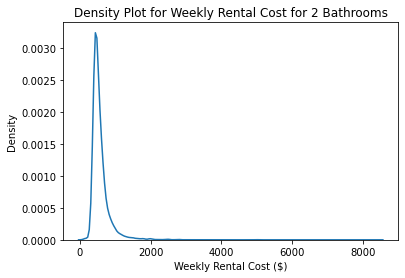

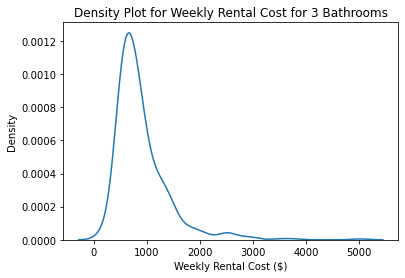

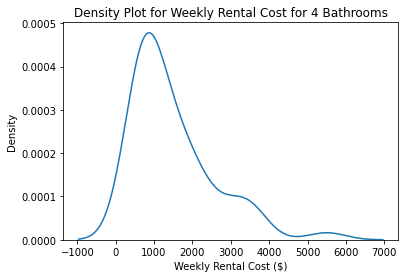

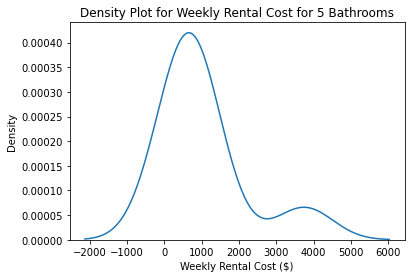

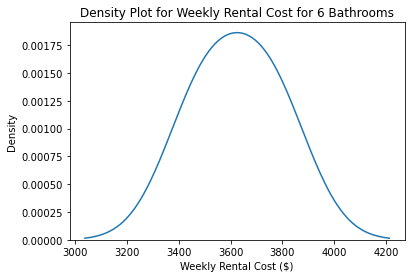

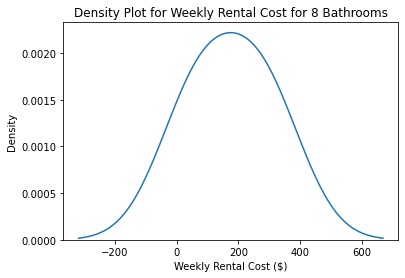

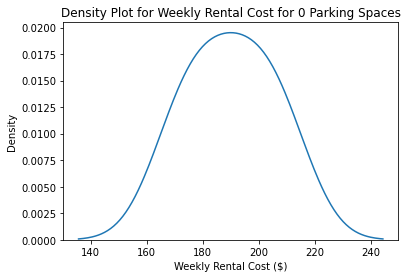

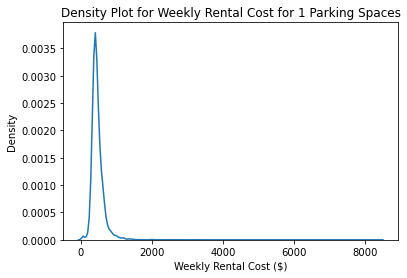

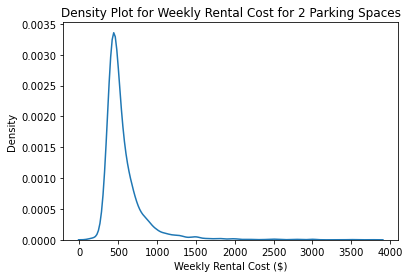

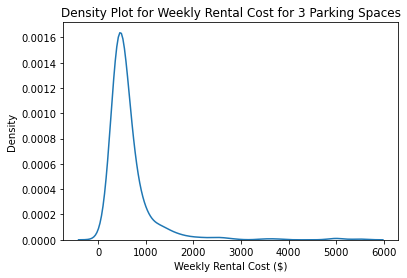

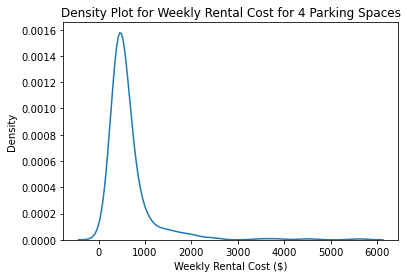

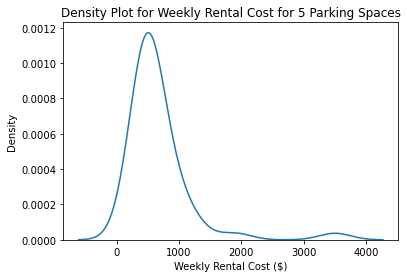

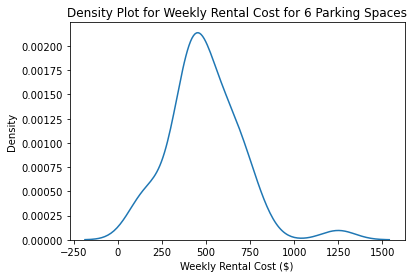

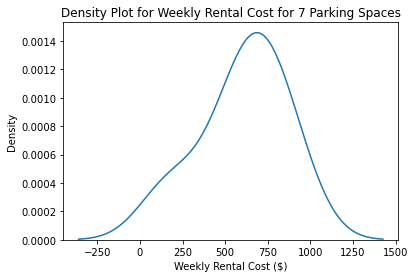

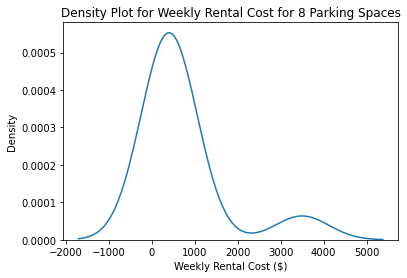

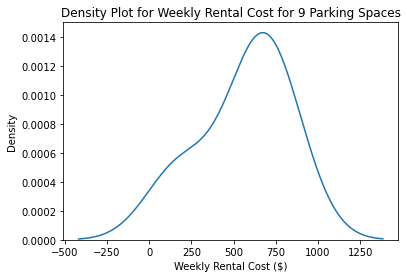

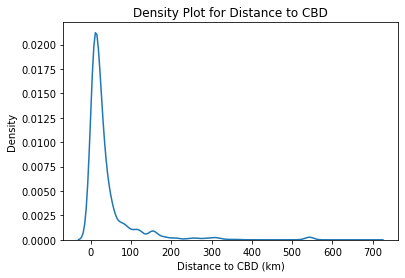

In [118]:
# Obtain recorded number of bedrooms, bathrooms and parking spaces (all unique values)
bedrooms_list = sorted(rental_df["bedrooms"].unique())
bathrooms_list = sorted(rental_df["bathrooms"].unique())
parking_spaces_list = rental_df["parking_spaces"].unique()
parking_spaces_list = sorted([int(i) for i in parking_spaces_list])

print(bedrooms_list)
print(bathrooms_list)
print(parking_spaces_list)

# Create density plots for the cost text of each unique number of bedrooms
for i in bedrooms_list:
    bedroom_df = rental_df[rental_df["bedrooms"]==i]
    kde_plot(bedroom_df, "cost_text", "Density Plot for Weekly Rental Cost for {bedroom} Bedrooms".format(bedroom = i), 
             "Weekly Rental Cost ($)", "density_plot_{bedroom}bedrooms".format(bedroom = i))
    
# Create density plots for the cost text of each unique number of bathrooms
for i in bathrooms_list:
    bathroom_df = rental_df[rental_df["bathrooms"]==i]
    kde_plot(bathroom_df, "cost_text", "Density Plot for Weekly Rental Cost for {bathroom} Bathrooms".format(bathroom = i), 
             "Weekly Rental Cost ($)", "density_plot_{bathroom}bathrooms".format(bathroom = i))

# Create density plots for the cost text of each unique number of parking spaces
for i in parking_spaces_list:
    parking_spaces_df = rental_df[rental_df["parking_spaces"]==i]
    kde_plot(parking_spaces_df, "cost_text", "Density Plot for Weekly Rental Cost for {parking_space} Parking Spaces".format(parking_space = i), 
             "Weekly Rental Cost ($)", "density_plot_{parking_space}parking_spaces".format(parking_space = i))

# Create density plot for distance to CBD
kde_plot(rental_df, "CBD_Distance", "Density Plot for Distance to CBD", "Distance to CBD (km)", "density_plot_distance_to_CBD")

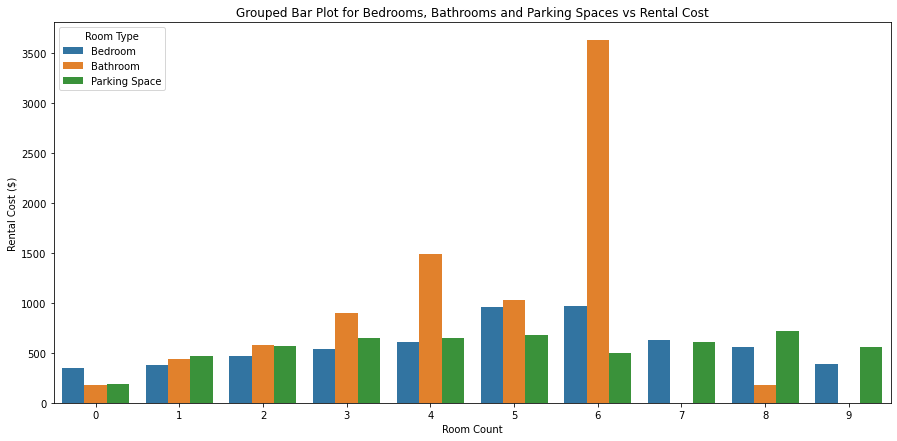

In [158]:
# Create grouped bar plot of number of bedrooms, bathrooms and parking spaces vs rental cost
grouped_bedrooms_df = rental_df[["bedrooms", "cost_text"]].groupby("bedrooms").agg({"cost_text": "mean"}).rename({"cost_text": "Bedroom"}, axis=1)
grouped_bathrooms_df = rental_df[["bathrooms", "cost_text"]].groupby("bathrooms").agg({"cost_text": "mean"}).rename({"cost_text": "Bathroom"}, axis=1)
grouped_parking_spaces_df = rental_df[["parking_spaces", "cost_text"]].groupby("parking_spaces").agg({"cost_text": "mean"}).rename({"cost_text": "Parking Space"}, axis=1)
grouped_rooms_df = pd.concat([grouped_bedrooms_df, grouped_bathrooms_df, grouped_parking_spaces_df], axis=1).melt()
grouped_rooms_df["room_count"] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(15,7))
grouped_barplot = sns.barplot(data=grouped_rooms_df, x="room_count", y="value", hue="variable")
grouped_barplot.legend(title="Room Type")
plt.xlabel("Room Count")
plt.ylabel("Rental Cost ($)")
plt.title("Grouped Bar Plot for Bedrooms, Bathrooms and Parking Spaces vs Rental Cost")
plt.show()
plt.close()

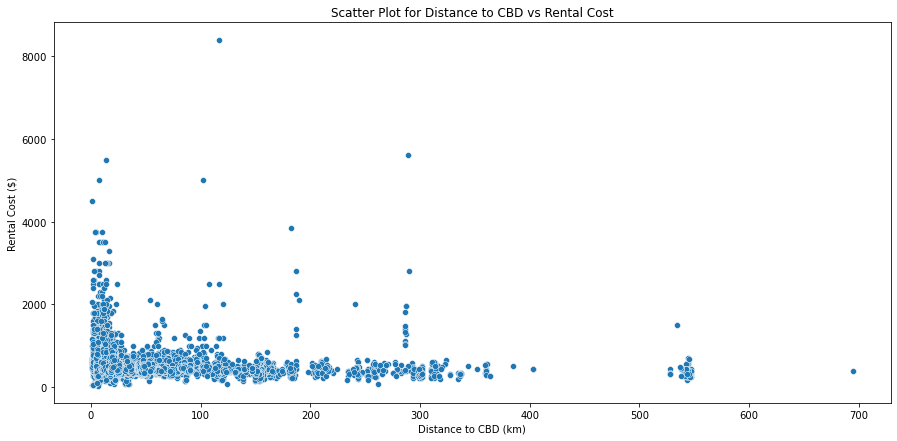

In [88]:
# Create scatter plot of distance to CBD vs rental cost
scatter_plot(rental_df, "CBD_Distance", "Distance to CBD (km)", "Scatter Plot for Distance to CBD vs Rental Cost")

In [62]:
# Colour code each suburb based on distance to CBD
rental_df = rental_df.dropna().reset_index(drop=True)
rental_df["colour"] = rental_df.apply(colour_code, axis=1)

# Create a list containing labels for distance range to CBD
distance = ["Within 10km to CBD", "Within 20km to CBD", "Within 30km to CBD", "Within 40km to CBD", "Within 50km to CBD", 
            "Within 60km to CBD", "Within 100km to CBD", "Within 150km to CBD", "Within 200km to CBD", "Within 700km to CBD"]

#Iterate through each row of dataframe and plot  vs percentage obese, colour coding based on lga distance to Melbourne
for index, row in sorted_soft_drink_df.iterrows():
    if index == 0:
        plt.scatter(sorted_soft_drink_df.iloc[index, 1], sorted_soft_drink_df.iloc[index, 3], color=sorted_soft_drink_df.iloc[index, 7], label=distance[distance_index])
    elif (sorted_soft_drink_df.iloc[index, 7] == sorted_soft_drink_df.iloc[index-1, 7]):
        plt.scatter(sorted_soft_drink_df.iloc[index, 1], sorted_soft_drink_df.iloc[index, 3], color=sorted_soft_drink_df.iloc[index, 7])
    else:
        distance_index += 1
        plt.scatter(sorted_soft_drink_df.iloc[index, 1], sorted_soft_drink_df.iloc[index, 3], color=sorted_soft_drink_df.iloc[index, 7], label=distance[distance_index])

NameError: name 'sorted_soft_drink_df' is not defined